In [12]:
import torch
from torch import nn, optim
import torch.nn.functional as F

import os, re

from src.models import rnn_sequence_model as stochseq
from src.models.rnn_sequence_model import get_data, fit, generate

In [23]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [13]:
def parse_filename(filename):
    # Define the regular expression pattern
    pattern = r"stochseq_model=(\w+)_layers=(\d+)_hidden=(\d+)\.pt"

    # Use regex to extract model and param
    match = re.match(pattern, filename)
    if match:
        model = match.group(1)
        layers = int(match.group(2))
        hidden = int(match.group(3))
        return model, layers, hidden
    else:
        return None

In [14]:
def find_matching_files(directory):
    files = os.listdir(directory)
    parsed = [(parse_filename(f), f) for f in files]
    
    return {x[0]: x[1] for x in parsed if x[0]}

In [15]:
models = find_matching_files('../models')

## Compute true covariance

In [16]:
kappa = 0.5
lamda = 1.0
rho = 1.0
mu = 1.0

sigma_ss = kappa / lamda
sigma_sx = rho * sigma_ss / (lamda + mu)
sigma_xx = rho / mu * (sigma_ss + sigma_sx)

def exp2(x, decay, scale):
    return scale * (-decay * x).exp()

def exprel(x):
    return torch.where(x.abs() > 1e-15, torch.special.expm1(x) / x, 1.0)

def cov_ss(t):
    return exp2(t, lamda, sigma_ss)

def cov_sx(t):
    scale1 = rho * sigma_ss * t * exprel((lamda - mu) * t)
    return exp2(t, mu, sigma_sx) + exp2(t, lamda, scale1)

def cov_xs(t):
    return exp2(t, lamda, sigma_sx)

def cov_xx(t):
    scale1 = rho * sigma_sx * t * exprel((lamda - mu) * t)
    return exp2(t, lamda, scale1) + exp2(t, mu, sigma_xx)

In [17]:
t = torch.linspace(-10.0, 10.0, steps=201)

In [18]:
true_cov = torch.stack((
    torch.stack((
        cov_ss(t.abs()),
        torch.where(t >= 0, cov_sx(t), cov_xs(-t)),
    )),
    torch.stack((
        torch.where(t >= 0, cov_xs(t), cov_sx(-t)),
        cov_xx(t.abs()),
    ))
))

## Compute MSE Loss for all models

In [24]:
corpus = torch.load('../data/gaussian_data.pt', device)
train_data = corpus['training']
val_data = corpus['validation']

In [27]:
def cross_cov(data, transpose=False):
    if transpose:
        data = data.transpose(0, 1)
    N, L = data.shape[1:]
    result = F.conv1d(data, data, padding=L) / N / L
    return torch.arange(-L,L+1), result.transpose(0, 1).cpu()

In [29]:
def get_mse_loss(filename):
    model = torch.load('../models/' + filename)
    pred, _ = generate(model, val_data[:,0,:])
    lags, cov = cross_cov(torch.stack((val_data[:,0,:], pred)))
    return F.mse_loss(cov, true_cov).item()

hp_data = { p: get_mse_loss(f) for p, f in models.items() }

In [30]:
import numpy as np

In [31]:
model_colors = { 'RNN': 'black', 'LSTM': 'green', 'GRU': 'red' }
layer_markers = {1: '.', 2: 'x'}
model_types = np.array([m for (m, _, _) in hp_data.keys()])
losses = np.fromiter(hp_data.values(), float)
layers = np.array([x for (_, x, _) in hp_data.keys()])
hidden = np.array([h for (_, _, h) in hp_data.keys()])

In [33]:
from matplotlib import pyplot as plt

Text(0.5, 0, 'number hidden dimensions')

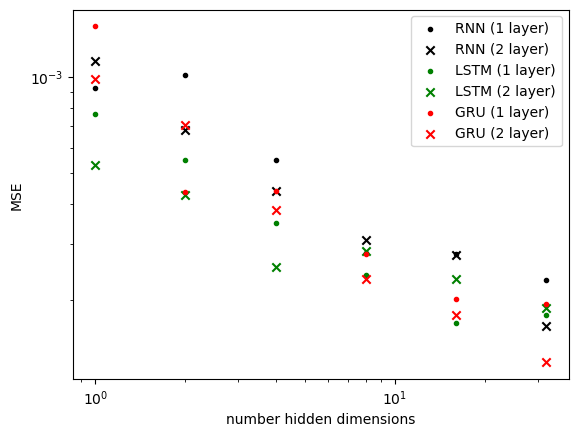

In [34]:
for model_type, c in model_colors.items():
    for i, marker in layer_markers.items():
        mask = np.logical_and((model_types == model_type), (layers == i))
        plt.scatter(hidden[mask], losses[mask], label=f"{model_type} ({i} layer)", c=c, marker=marker)
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.ylabel('MSE')
plt.xlabel('number hidden dimensions')

## Analyze single model

In [383]:
model = torch.load('../models/' + models[('GRU', 2, 32)])

In [384]:
model

SequenceModel(
  (rnn): GRU(2, 32, num_layers=2, batch_first=True)
  (linear): Linear(in_features=33, out_features=2, bias=True)
)

In [390]:
pred, _ = generate(model, val_data[:,0,:], device='cuda')
lags, cov = cross_cov(torch.stack((val_data[:,0,:], pred)))

Text(0.5, 1.0, 'true')

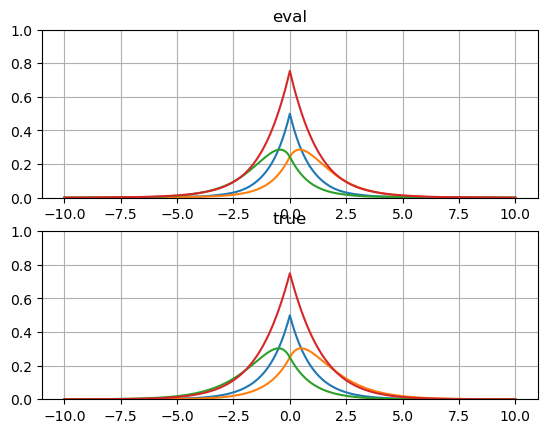

In [392]:
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(t, cov.flatten(0, 1).numpy().T)
ax2.plot(t, true_cov.flatten(0, 1).numpy().T)
for ax in (ax1, ax2):
    ax.grid()
    ax.set_ylim(0,1)
ax1.set_title('eval')
ax2.set_title('true')

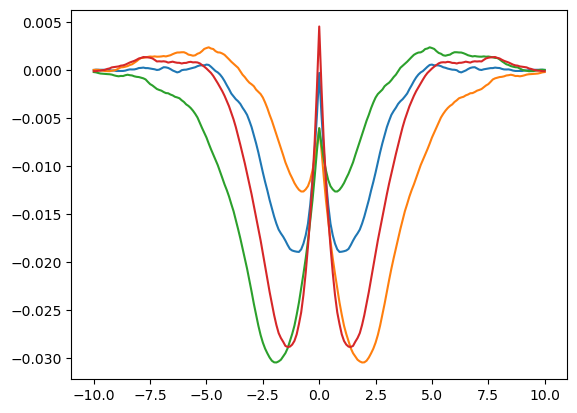

In [394]:
plt.plot(t, ((cov - true_cov)).flatten(0, 1).numpy().T)